<a href="https://www.kaggle.com/code/maciejk111/carvsplanevsship?scriptVersionId=128383275" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import random
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

importing all tools I need and importing my custom dataset 

In [2]:
dataset = ImageFolder('/kaggle/input/car-or-plane-or-ship/train')
print(len(dataset))
print(len(dataset.classes))

3578
3


creating classes

In [3]:
vessel_class = []

def rename(name):
    return name

for n in dataset.classes:
    vessel_class.append(rename(n))

In [4]:
vessel_class

['airplanes', 'cars', 'ship']

Dividing data on training, test and validation parts.

In [5]:
random_seed = 69
torch.cuda.manual_seed_all(random_seed)
torch.manual_seed(random_seed);

test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size




train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
print(len(train_ds), len(val_ds), len(test_ds))

2255 250 1073


Images in my dataset are in the PIL format so i need to applay more transformations in order to get dataset with data augumentation. I use data augemantation to prevent overfitting, which in such a model could be a problem.

2


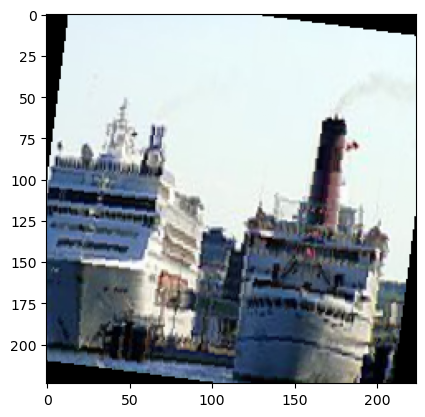

In [6]:
class vessel_classes_dataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label
        
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

train_dataset = vessel_classes_dataset(train_ds, train_transform)
val_dataset = vessel_classes_dataset(val_ds, val_transform)
test_dataset =vessel_classes_dataset(test_ds, test_transform)

img, label = train_dataset[random.randint(0,1000)]
print(label)
plt.imshow(img.permute(1,2,0))

Here i create Dataloaders.

In [7]:
batch_size =64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

Here I define neural network model with the general base class for image classification and model "wide_resnet50", which was choosen by me due to it's general good performance - it achieves good accuracy while at the same time it does not consume that much of compilatory power

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        
        
class vessel_class_WideResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.wide_resnet50_2(pretrained=True)
        
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 3),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [9]:
model1 =  vessel_class_WideResnet()
model1

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

vessel_class_WideResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

Here I move data to the GPU, the GPU I'm using is Tesla P100 provided for free by kaggle.

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)
    
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)
    
    
device = get_default_device()
print(device)

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

cuda


In [11]:
to_device(model1, device)

vessel_class_WideResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

here i check the model

In [12]:
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model1(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_loader)

images shape :  torch.Size([64, 3, 224, 224])
labels :  tensor([2, 1, 2, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 0, 0,
        1, 1, 2, 1, 2, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 0,
        1, 0, 1, 0, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 2, 2], device='cuda:0')
outs.shape : torch.Size([64, 3])
outs :  tensor([[-1.1053, -0.9828, -1.2220],
        [-1.2696, -0.8544, -1.2259],
        [-1.0229, -0.9573, -1.3607],
        [-1.2799, -0.9925, -1.0462],
        [-0.9493, -1.0701, -1.3093],
        [-1.0465, -1.2002, -1.0564],
        [-1.0052, -1.0497, -1.2589],
        [-1.0587, -1.1477, -1.0915],
        [-1.1002, -1.4970, -0.8133],
        [-0.9433, -1.0602, -1.3308],
        [-1.0082, -1.0892, -1.2085],
        [-1.0741, -1.0325, -1.1964],
        [-1.1702, -1.1173, -1.0146],
        [-0.8690, -1.4604, -1.0542],
        [-0.7606, -1.1594, -1.5190],
        [-1.1594, -0.9986, -1.1459],
        [-1.1167, -1.0996, -1.0799],
        [-1.0218, -1.0428, -1.2462],
   

her I decided to visualise my augumented batch

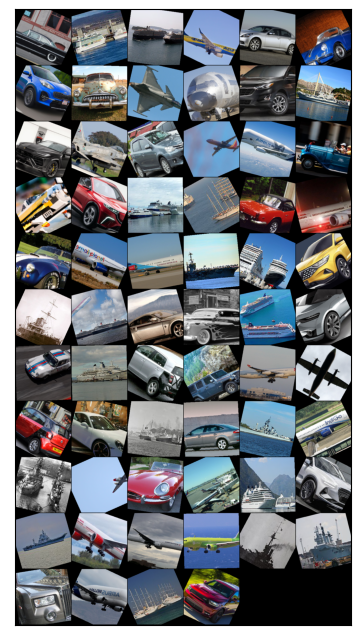

In [13]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=6).permute(1,2,0))
        break
        
show_batch(train_loader)

A whise man said me once that key to being AI engenieer is to "visualise! visualise! visualise!" so I'm importing a loading bar for better visualisation

In [14]:
from tqdm.notebook import tqdm

Implementation of training and evaluation of my model. I have decided to use "train_one_cycle" which will change the learning rate after every batch of training

In [15]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader1, val_loader1, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader1))
    
    for epoch in range(epochs):
        
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader1):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            
           
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
        
            sched.step()
            
        result = evaluate(model, val_loader1)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader1):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader1]
    return model.validation_epoch_end(outputs)

In [16]:
evaluate(model1, val_loader)

{'val_loss': 1.0414402484893799, 'val_acc': 0.4597848355770111}

setting hyperparameters

In [17]:
num_epochs = 5
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [18]:
history = fit_one_cycle(num_epochs, max_lr, model1, train_loader, val_loader, weight_decay, grad_clip, opt_func)

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.4934, val_loss: 0.0073, val_acc: 0.9959


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.0254, val_loss: 0.0187, val_acc: 0.9959


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.0046, val_loss: 0.0201, val_acc: 0.9959


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.0025, val_loss: 0.0231, val_acc: 0.9959


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0043, val_loss: 0.0201, val_acc: 0.9959


In [19]:
num_epochs = 3
max_lr = 0.001
history += fit_one_cycle(num_epochs, max_lr, model1, train_loader, val_loader, weight_decay, grad_clip, opt_func)

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.0036, val_loss: 0.0178, val_acc: 0.9959


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.0028, val_loss: 0.0163, val_acc: 0.9959


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.0017, val_loss: 0.0174, val_acc: 0.9959


In [20]:
num_epochs = 2
max_lr = 0.0001
history += fit_one_cycle(num_epochs, max_lr, model1, train_loader, val_loader, weight_decay, grad_clip, opt_func)

  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.0016, val_loss: 0.0171, val_acc: 0.9959


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.0031, val_loss: 0.0114, val_acc: 0.9959


Visualise loss per epochs (red = validation loss, blue = training loss)

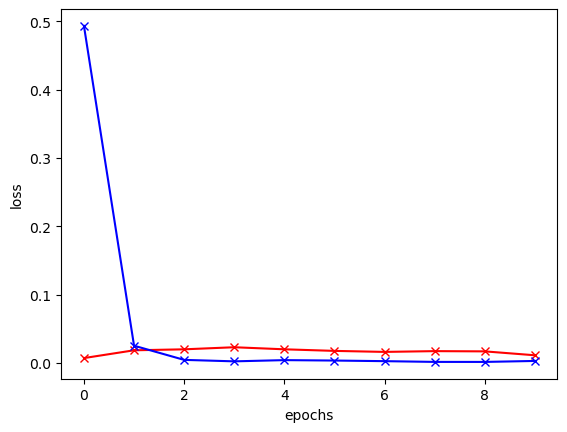

In [21]:
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])
    
    
    
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

accuracy per epochs

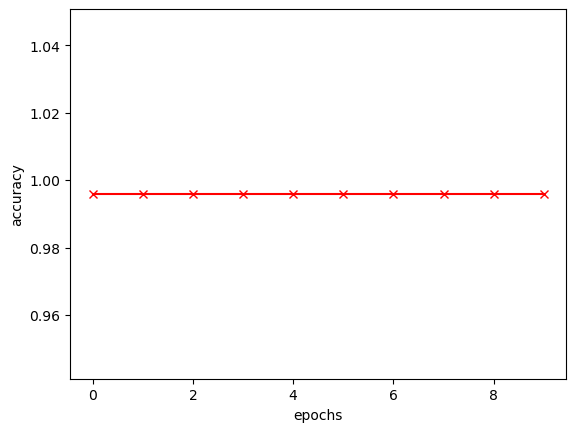

In [22]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

learning rate per epochs

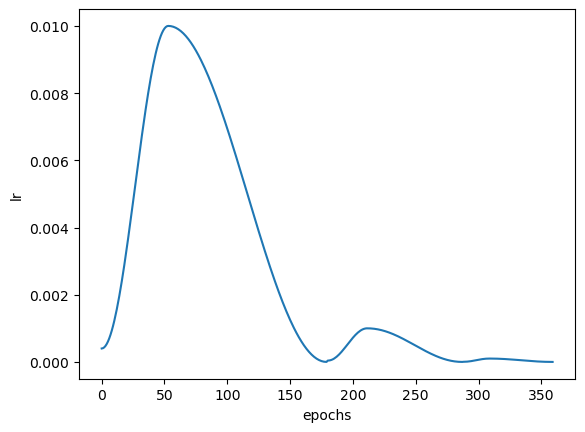

In [23]:
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.xlabel('epochs')
plt.ylabel('lr')
plt.plot(lrs)
plt.show()

In [24]:
def predict_single(img, label):
    xb = img.unsqueeze(0) 
    xb = to_device(xb, device)
    preds = model1(xb)                   
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    print('Actual :', vessel_class[label], ' | Predicted :', vessel_class[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()

lets test that beast!

Actual : ship  | Predicted : ship


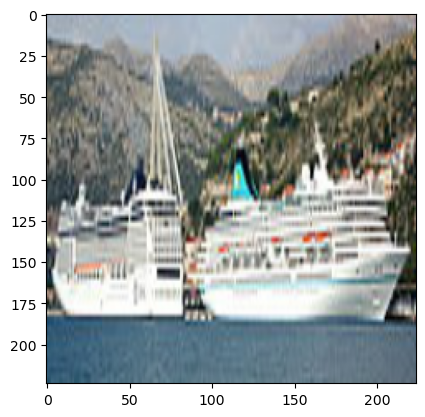

In [25]:
predict_single(*test_dataset[2])

Actual : cars  | Predicted : cars


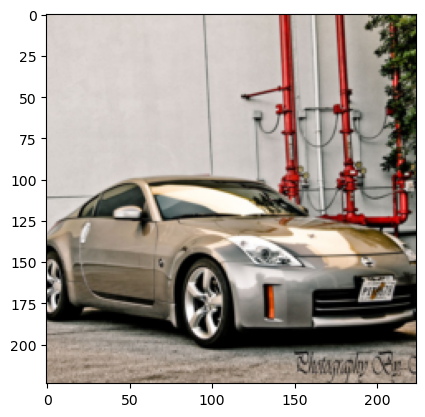

Actual : airplanes  | Predicted : airplanes


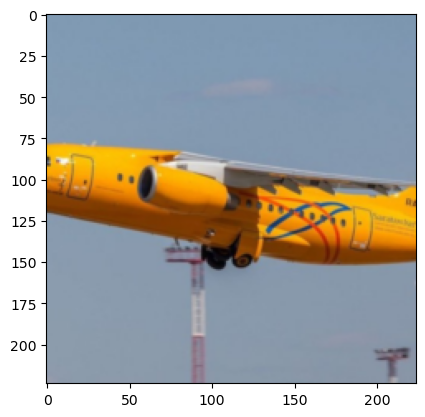

Actual : ship  | Predicted : ship


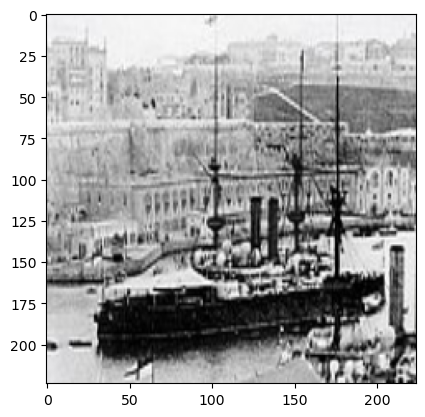

Actual : airplanes  | Predicted : airplanes


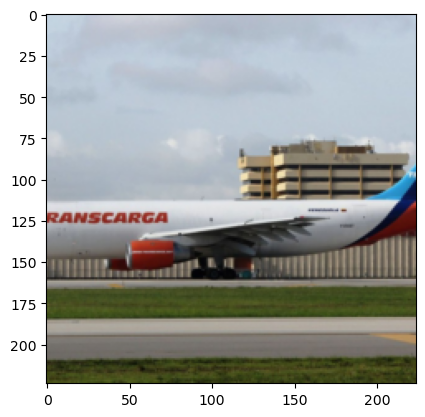

Actual : airplanes  | Predicted : airplanes


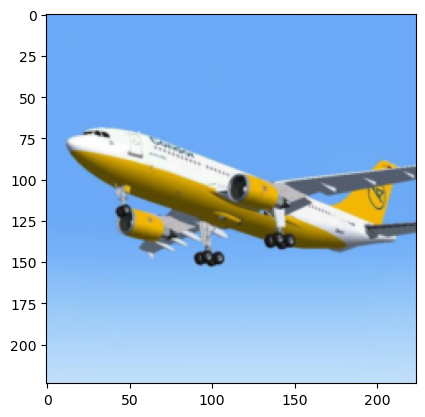

Actual : airplanes  | Predicted : airplanes


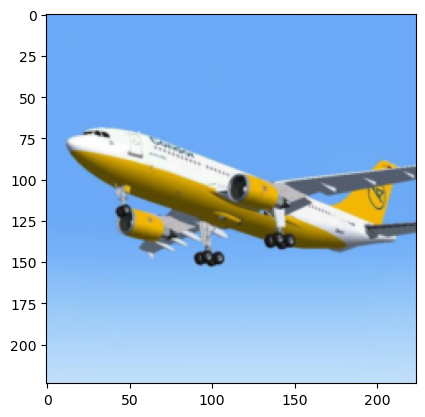

Actual : cars  | Predicted : cars


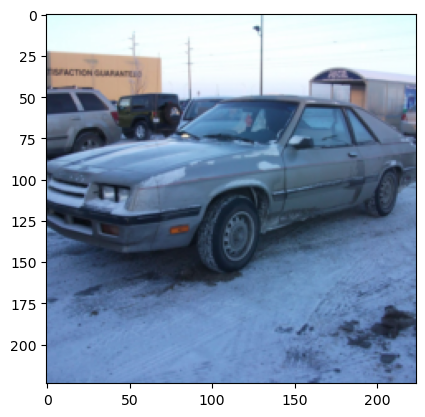

Actual : ship  | Predicted : ship


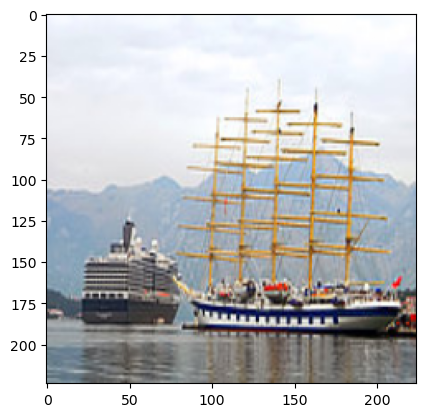

Actual : airplanes  | Predicted : airplanes


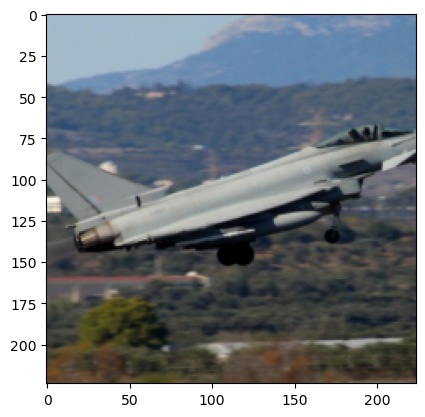

Actual : ship  | Predicted : ship


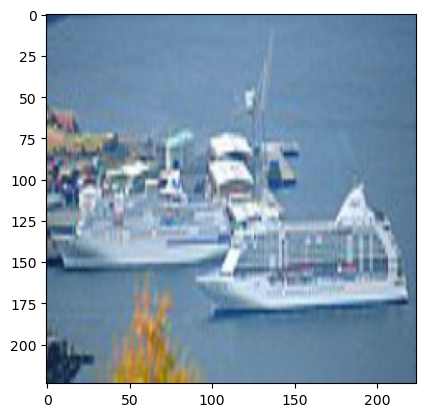

In [26]:
import random

for i in range(10):
    random_label = random.randint(1,621)
    img, label = test_dataset[random_label]
    predict_single(img, label)

Lets's call evaluate on the test dataloader

In [27]:
test_dl = DeviceDataLoader(test_loader, device)
result = evaluate(model1, test_dl)
result

{'val_loss': 0.0015249954303726554, 'val_acc': 1.0}

The level of accuracy of the dataset is almost 100%! 
(ok, I know that 0.9991319179534912 is not equal to 1 but that's why i said "almost") 
Accuracy is good, but let's be honest that data set was ridiculously easy and the model I used ii was such an overkill. But still I'm proud for my model!

In [28]:
#now just save it 
weights_fname = 'vessel_classification-wideresnet_with_Daug.pth'
torch.save(model1.state_dict(), weights_fname)